(4032, 3024, 3)


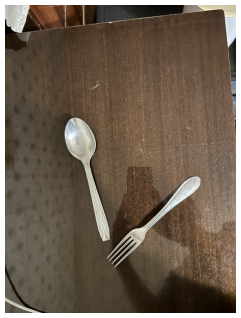

In [138]:
import cv2
import numpy as np
import onnx
import onnxruntime
import matplotlib.pyplot as plt


# Загрузка модели ONNX
onnx_model = onnx.load("best.onnx")

# Создание сессии ONNX
ort_session = onnxruntime.InferenceSession("best.onnx")

image = cv2.imread("./YOLO_dataset/validation/images/IMG_7923.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_height, img_width, _ = image.shape
print(image.shape)

plt.figure(figsize=(8, 8), dpi=50)
plt.imshow(image)
plt.axis('off')
plt.show()

In [3]:
# Преобразование к размерности модели: (1, 3, H, W)

resized_image = cv2.resize(image.copy(), (640, 640))
frame_transpose = np.transpose(resized_image, (2, 0, 1)).astype(np.float32)
frame_norm = frame_transpose / 255.0
result_frame = np.expand_dims(frame_norm, axis=0)

print(result_frame.shape)

(1, 3, 640, 640)


In [4]:
# Предсказание модели

outputs = ort_session.run(None, {'images': result_frame})

outputs содержит 8400 обнаруженных объектов (большая часть из них мусор), однако каждый из них имеет 38 параметров вместо 84 (для дефолтной модели YOLO). Это связано с тем, что он содержит дополнительные N параметров для масок сегментации.  
Этот вывод включает в себя те же 84 параметра модели обнаружения объектов и 32 маски сегментации. Вот почему нужно разделить этот ввод на две части.  
Имейте в виду, что если вы используете специально обученную модель, количество классов может быть не 80, а другое число. В этом случае вам нужно использовать (количество классов)+4, чтобы разделить вывод на поля и маски, а не 84.

In [5]:
output0 = outputs[0]
output1 = outputs[1]

print("Длина всего объекта output:", len(outputs))
print("output0:", output0.shape)
print("output1:", output1.shape)

Длина всего объекта output: 2
output0: (1, 38, 8400)
output1: (1, 32, 160, 160)


In [6]:
output0 = output0[0].transpose()
output1 = output1[0]
print("output0:", output0.shape)
print("output1:", output1.shape)

output0: (8400, 38)
output1: (32, 160, 160)


In [7]:
# Определение boxes и masks

boxes = output0[:,:6]
masks = output0[:,6:]
print("boxes:", boxes.shape)
print("masks:", masks.shape)

boxes: (8400, 6)
masks: (8400, 32)


In [8]:
output1 = output1.reshape(32, 160*160)
print(masks.shape, output1.shape)

(8400, 32) (32, 25600)


In [9]:
# маски сегментации для всех обнаруженных боксов. Каждая маска сегментации имеет размер 160x160.

masks = masks @ output1
print(masks.shape)

(8400, 25600)


In [10]:
# Соединение масок и боксов в один тензор

boxes = np.hstack([boxes, masks])
print(boxes.shape)

(8400, 25606)


In [11]:
# Обработка boxes, чтот бы получить список bounding boxes
# Их маски сегментации и полигоны

classes = ["knife", "spoon"]

def intersection(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    x1 = max(box1_x1,box2_x1)
    y1 = max(box1_y1,box2_y1)
    x2 = min(box1_x2,box2_x2)
    y2 = min(box1_y2,box2_y2)
    return (x2-x1)*(y2-y1) 

def union(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
    box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
    return box1_area + box2_area - intersection(box1,box2)

def iou(box1,box2):
    return intersection(box1,box2)/union(box1,box2)

In [144]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

# parse segmentation mask
def get_mask(row, box, img_width, img_height):
    # convert mask to image (matrix of pixels)
    mask = row.reshape(160,160)
    mask = sigmoid(mask)
    mask = (mask > 0.5).astype("uint8")*255
    
    # crop the object defined by "box" from mask
    x1,y1,x2,y2 = box
    mask_x1 = round(x1/img_width*160)
    mask_y1 = round(y1/img_height*160)
    mask_x2 = round(x2/img_width*160)
    mask_y2 = round(y2/img_height*160)
    
    # resize the cropped mask to the size of object
    img_mask = np.uint8(mask)
    
    # plt.figure(figsize=(8, 8), dpi=70)
    # plt.imshow(img_mask, "gray")
    # plt.axis('off')
    # plt.show()
    
    img_mask = np.resize(img_mask, (round(x2-x1),round(y2-y1)))
    mask = np.array(img_mask)
    return mask

# calculate bounding polygon from mask
def get_polygon(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # polygon = [[contour[0][0],contour[0][1]] for contour in contours[0][0]]

    return contours

# parse and filter all boxes
objects = []
for row in boxes:
    xc,yc,w,h = row[:4]
    x1 = (xc-w/2)/640*img_width
    y1 = (yc-h/2)/640*img_height
    x2 = (xc+w/2)/640*img_width
    y2 = (yc+h/2)/640*img_height
    prob = row[4:6].max()
    if prob < 0.4:
        continue
    class_id = row[4:6].argmax()
    label = classes[class_id]
    mask = get_mask(row[6:25606], (x1,y1,x2,y2), img_width, img_height)
    polygon = get_polygon(mask)
    objects.append([x1,y1,x2,y2,label,prob,mask,polygon])


# apply non-maximum suppression
objects.sort(key=lambda x: x[5], reverse=True)
result = []
while len(objects)>0:
    result.append(objects[0])
    objects = [cur_object for cur_object in objects if iou(cur_object, objects[0])<0.7]

print("Количесто обнаруженных объектов =", len(result))

Количесто обнаруженных объектов = 1


In [146]:
# Отображение bounding boxes и сегментов на входном изображении
# image = cv2.imread("./YOLO_dataset/validation/images/IMG_7923.jpeg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# for object_cur in result:
#     [x1,y1,x2,y2,label,prob,mask,polygon] = object_cur
#     polygon = [(int(x1+point[0]),int(y1+point[1])) for point in polygon]
#     # cv2.drawContours(image, polygon, -1, (0,255,0), 5)
#     # cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), thickness=5)

# plt.figure(figsize=(8, 8), dpi=70)
# plt.imshow(image)
# plt.axis('off')
# plt.show()